# Library Importation


In [3]:
import pandas as pd
import numpy as np
import spacy
import re
import threading

In [4]:
nlp = spacy.load("en_core_web_sm")

# Version 1 Hand Coded

In [5]:
class PII_Logging:
    def __init__(
        self, data, output=False, replace=False, log_type="Block", debug=False
    ):
        """Class to detect and redact PII information in a given text.

        Args:
            data (str): logs to be processed in the form of a string.
            output (bool, optional): Whether to output the Flagged values in Debug mode. Defaults to False.
            replace (bool, optional): Whether to replace the PII information with "REDACTED". Defaults to False.
            log_type (str, optional): How to handle the PII information. Defaults to "Block".
            debug (bool, optional): Option to print debug statements. Defaults to False.
        """
        self.data = data
        self.output = output
        self.replace = replace
        self.log_type = log_type
        self.debug = debug
        self.PII_KEYWORD = {}
        self.PII_PATTERN = {
            "EMAIL": 0,
            "PHONE": 0,
            "SSN": 0,
            "Credit_Card": 0,
            "Expiration_Date": 0,
            "CVV": 0,
            "Driver's_License": 0,
            "Names": 0,
            "Dates": 0,
            "Addresses": 0,
            "Sensitive_Words": 0,
            "IPV6_Address": 0,
            "IPv4_Address": 0,
        }
        self.PII_OUTPUT = {}
        length = data.split(". ")
        for line_num in range(len(length)):
            self.PII_OUTPUT[line_num] = []

        self.output_function(data)

    def extract_match(self, pattern, text):
        """Helper to extract matched string or return None

        Args:
            pattern (str): The pattern to search for.
            text (str): The text to search in.

        Returns:
            str: The matched string or None if no match is found.
        """

        match = re.search(pattern, text)
        return match.group() if match else None

    def redaction(self, flags, text):
        """Redacting the PII information

        Args:
            flags (dict): The dictionary of flagged values.
            text (str): The text to redact.

        Returns:
            str: The redacted text.
        """

        for index, flag in flags.items():
            for word in flag:
                text = re.sub(word, "REDACTED", text)
        return text

    def keyword_detection(self, data):
        """Using NER to detect Key Information

        Args:
            data (str): The text to process.

        Returns:
            str: The processed text.
        """
        rows = data.split(". ")
        for row, sentence in enumerate(rows):
            doc = nlp(sentence)
            for token in doc.ents:
                if token.label_ in ["PERSON", "ORG", "GPE", "DATE"]:
                    if token.label_ not in self.PII_KEYWORD:
                        self.PII_KEYWORD[token.label_] = []
                if token.label_ in ["DATE"]:
                    self.PII_PATTERN["Dates"] += 1
                    self.PII_OUTPUT[row].append(token.text)
                if token.label_ in ["PERSON"]:
                    self.PII_PATTERN["Names"] += 1
                    self.PII_OUTPUT[row].append(token.text)
                if token.label_ in ["GPE"]:
                    self.PII_PATTERN["Addresses"] += 1
                    self.PII_OUTPUT[row].append(token.text)
                if token.label_ in ["ORG"]:
                    self.PII_PATTERN["Sensitive_Words"] += 1
                    self.PII_OUTPUT[row].append(token.text)

    def pattern_detection(self, data):
        """Using regex to detect Key Information

        Args:
            data (str): The text to process.

        Returns:
            str: The processed text.
        """
        patterns = {
            "EMAIL": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b",
            "PHONE": r"\b(?:\+?1[\s.-]?)?(\(?\d{3}\)?[\s.-]?)\d{3}[\s.-]?\d{4}\b",
            "SSN": r"\b\d{3}-\d{2}-\d{4}\b",
            "Credit_Card": r"\b\d{4}-\d{4}-\d{4}-\d{4}\b|\b\d{16}\b",
            "Expiration_Date": r"\b\d{2}/\d{2}\b",
            "CVV": r"(?i)(cvv|cvc|cid|security\s+code)[\s:]*['\"]?\d{3,4}['\"]?",
            "Driver's_License": r"(?i)\b(?:[A-Z]{1,3}\d{4,8}|[A-Z]\d{6,12}|\d{3}[A-Z]{2}\d{4})\b",
            "Addresses": r"(\d{1,5}\s\w+\s\w+)|(P\.O\.\sBox\s\d+)|(\d{5})",
            "IPv4_Address": r"\b(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(?:\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}\b",
            "IPV6_Address": r"(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,7}:|:(:[0-9a-fA-F]{1,4}){1,7}|([0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,5}(:[0-9a-fA-F]{1,4}){1,2}|([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,3}|([0-9a-fA-F]{1,4}:){1,3}(:[0-9a-fA-F]{1,4}){1,4}|([0-9a-fA-F]{1,4}:){1,2}(:[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:((:[0-9a-fA-F]{1,4}){1,6})|::((:[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|(::ffff|::)ffff:([0-9]{1,3}\.){3}[0-9]{1,3}",
        }
        rows = data.split(". ") if isinstance(data, str) else data
        for row, text in enumerate(rows):
            for category, pattern in patterns.items():
                match = self.extract_match(pattern, text)
                if match:
                    self.PII_PATTERN[category] += 1
                    self.PII_OUTPUT[row].append(match)

    def detect_pii(self, data):
        """Uses Multithreading to process the text Calling prior functions.

        Args:
            data (str): The text to process.
        """

        doc = data
        keyword = threading.Thread(target=self.keyword_detection, args=(doc,))
        pattern = threading.Thread(target=self.pattern_detection, args=(doc,))
        keyword.start()
        pattern.start()
        keyword.join()
        pattern.join()

    def output_function(self, data):
        """Output function that handles the output of the PII information.

        Args:
            data (str): The text to process.
        """
        self.detect_pii(data)
        for category in self.PII_PATTERN:
            if self.PII_PATTERN[category] > 0:
                if self.debug:
                    print(
                        f"""PII Detected in category: {category}\nNumber Detected: {self.PII_PATTERN[category]}"""
                    )
        if self.replace:
            self.doc_redacted = self.redaction(self.PII_OUTPUT, data)
        if self.output:
            if self.debug:
                if self.replace:
                    print(f"\n{self.doc_redacted}")
                print("\nFlagged Sentences:")
                print(self.PII_OUTPUT)

        if max(self.PII_PATTERN.values()) > 0:
            if self.log_type == "Block":
                print("PII Detected Entry is Not Loggable")
            elif self.log_type == "Mask":
                print("PII Detected Entry is Redacted")
            elif self.log_type == "Log":
                print("PII Detected: Message Logged Anyways")

In [6]:
ner_text = "John Smith, a resident of New York, contacted Acme Corp on Jan 1st. His colleague, Maria Garcia from Boston, also sent an inquiry."
customer = "Customer Jane Doe (email: jane.d@email.net, DOB: 1990-05-15) called to report an issue. She lives at 123 Main St, Anytown, USA 12345. Verified identity with SSN ending in 5678. Contact number is 555-123-4567."
transaction = "Transaction record for account ending in 4401. Credit Card: 4111-1111-1111-1111, Exp: 12/26. Driver's License #: D12345678."

fake_email1 = """From: john.smith@examplecorp.com
To: contact@acmecorp.com
Date: January 1, 2025, 10:15 AM EST
Subject: Inquiry Regarding Potential Enterprise Partnership

Dear Acme Corp Team,

My name is John Smith, and I am a Senior Project Manager based in New York. I am writing to express our strong interest in your enterprise-level data solutions. Our team has been following Acme Corp's innovations for some time, and we believe your platform could be a significant asset to our upcoming Q2 initiatives.

I would appreciate it if you could provide some preliminary information on your enterprise licensing model and any available case studies relevant to the logistics sector.

My colleague, Maria Garcia, who is based in our Boston office, will also be sending a separate inquiry with some more technical questions. We are working together on this evaluation project.

Thank you for your time and assistance.

Sincerely,

John Smith
Senior Project Manager
ExampleCorp | New York, NY"""
fake_email2 = """From: maria.garcia@examplecorp.com
To: contact@acmecorp.com
Date: January 2, 2025, 11:30 AM EST
Subject: Technical Questions - Following up on John Smith's Inquiry

Dear Acme Corp Team,

I am writing to follow up on the email sent yesterday by my colleague, John Smith. As he mentioned, my name is Maria Garcia, and I am the lead solutions architect for his team.

Building on John's request, I have a few specific technical questions regarding your platform's API integration capabilities:

What are the standard rate limits for API calls on your enterprise plan?

Do you offer support for custom data connectors, specifically for SAP S/4HANA?

Could you provide documentation on your security and data encryption protocols?

We are very excited about the possibility of a partnership. The answers to these questions will be crucial for our internal technical assessment.

Thank you,

Maria Garcia
Lead Solutions Architect
ExampleCorp | Boston, MA"""
dictionary_format = """{
  "timestamp": "2024-05-21T10:00:00Z",
  "level": "INFO",
  "message": "User login successful for user_email: test@example.com",
  "details": {
    "ip_address": "192.168.1.1",
    "user_agent": "Mozilla/5.0",
    "contact": "For support, call 555-123-4567.",
    "ssn_ref": "User SSN is 987-65-4321 for verification."
  }
}"""

Clean_Example1 = """From: [REDACTED EMAIL]
To: [REDACTED EMAIL]
Subject: Update on Ticket #[REDACTED ID]

Dear Support Team,

I am writing to follow up on a support ticket I filed on [REDACTED DATE].

My name is [REDACTED NAME], and my account number is [REDACTED ID]. The issue was regarding a delivery that was supposed to be sent to my address at [REDACTED ADDRESS].

A support agent mentioned that the technical team was looking into an issue and would call me back at [REDACTED PHONE], but I have not yet received a call. The case was logged from my home computer, which has the IP address [REDACTED IP].

Could you please provide an update on the status of my ticket?

Thank you,

[REDACTED NAME]"""

In [7]:
_ = PII_Logging(
    dictionary_format, output=True, replace=True, debug=False, log_type="Log"
)

PII Detected: Message Logged Anyways


# Version 2 Assisted Coded

In [8]:
# Enhanced PII_Logging class with proximity analysis, graph-based analysis, and deduplication
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict


class Enhanced_PII_Logging:
    def __init__(
        self,
        data,
        output=False,
        replace=False,
        log_type="Block",
        debug=False,
        enable_proximity=True,
        enable_graph=True,
        window_size=50,
    ):
        """Enhanced class to detect and redact PII information with advanced analysis methods.

        Args:
            data (str): logs to be processed in the form of a string.
            output (bool, optional): Whether to output the Flagged values in Debug mode. Defaults to False.
            replace (bool, optional): Whether to replace the PII information with "REDACTED". Defaults to False.
            log_type (str, optional): How to handle the PII information. Defaults to "Block".
            debug (bool, optional): Option to print debug statements. Defaults to False.
            enable_proximity (bool, optional): Enable proximity analysis. Defaults to True.
            enable_graph (bool, optional): Enable graph-based analysis. Defaults to True.
            window_size (int, optional): Window size for proximity analysis. Defaults to 50.
        """
        self.data = data
        self.output = output
        self.replace = replace
        self.log_type = log_type
        self.debug = debug
        self.enable_proximity = enable_proximity
        self.enable_graph = enable_graph
        self.window_size = window_size

        # Initialize tracking dictionaries
        self.PII_KEYWORD = {}
        self.PII_PATTERN = {
            "EMAIL": 0,
            "PHONE": 0,
            "SSN": 0,
            "Credit_Card": 0,
            "Expiration_Date": 0,
            "CVV": 0,
            "Driver's_License": 0,
            "Names": 0,
            "Dates": 0,
            "Addresses": 0,
            "Sensitive_Words": 0,
            "IPV6_Address": 0,
            "IPv4_Address": 0,
        }

        # Enhanced tracking for deduplication
        self.PII_OUTPUT = {}
        self.PII_DETAILS = (
            {}
        )  # Store detailed findings with confidence and method
        self.UNIQUE_PII = set()  # Track unique PII values to prevent duplicates

        # Split data into sentences
        length = data.split(". ")
        for line_num in range(len(length)):
            self.PII_OUTPUT[line_num] = []
            self.PII_DETAILS[line_num] = []

        # Proximity analysis keywords for enhanced detection
        self.proximity_keywords = {
            "SSN": ["ssn", "social security", "social", "ss#", "ss #"],
            "EMAIL": ["email", "e-mail", "mail", "contact"],
            "PHONE": ["phone", "telephone", "call", "contact", "mobile"],
            "Credit_Card": [
                "credit card",
                "card number",
                "cc",
                "visa",
                "mastercard",
            ],
            "CVV": ["cvv", "cvc", "security code", "verification code"],
            "Driver's_License": ["driver", "license", "dl", "driving"],
            "Addresses": [
                "address",
                "street",
                "avenue",
                "road",
                "city",
                "state",
                "zip",
            ],
            "Names": ["name", "person", "individual", "customer", "user"],
            "Dates": ["date", "birth", "dob", "born", "created", "modified"],
        }

        self.output_function(data)

    def extract_match(self, pattern, text):
        """Helper to extract matched string or return None"""
        match = re.search(pattern, text)
        return match.group() if match else None

    def redaction(self, flags, text):
        """Redacting the PII information"""
        for index, flag in flags.items():
            for word in flag:
                text = re.sub(re.escape(word), "REDACTED", text)
        return text

    def proximity_analysis(self, text, pattern, keywords, category):
        """
        Finds a pattern and then checks for keywords within a surrounding window.
        Returns findings with confidence levels.
        """
        findings = []
        matches = re.finditer(pattern, text, re.IGNORECASE)

        for match in matches:
            start, end = match.span()
            window_start = max(0, start - self.window_size)
            window_end = min(len(text), end + self.window_size)
            context_window = text[window_start:window_end]

            found_keyword = None
            for keyword in keywords:
                if re.search(
                    r"\b" + re.escape(keyword) + r"\b",
                    context_window,
                    re.IGNORECASE,
                ):
                    found_keyword = keyword
                    break

            confidence = "High" if found_keyword else "Low"
            findings.append(
                {
                    "value": match.group(0),
                    "confidence": confidence,
                    "method": "proximity_analysis",
                    "reason": (
                        f"Found nearby keyword: '{found_keyword}'"
                        if found_keyword
                        else "No nearby keywords found."
                    ),
                    "context": f"...{context_window}...",
                }
            )
        return findings

    def graph_based_analysis(self, data):
        """
        Builds a graph from records to find clusters of related PII.
        For text data, we'll extract potential PII and build relationships.
        """
        # Extract potential PII from text using existing patterns
        potential_pii = []
        sentences = data.split(". ")

        for sentence in sentences:
            # Extract various PII types
            email_matches = re.findall(
                r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", sentence
            )
            phone_matches = re.findall(
                r"\b(?:\+?1[\s.-]?)?(\(?\d{3}\)?[\s.-]?)\d{3}[\s.-]?\d{4}\b",
                sentence,
            )
            ssn_matches = re.findall(r"\b\d{3}-\d{2}-\d{4}\b", sentence)
            name_matches = []

            # Use spaCy for name extraction
            doc = nlp(sentence)
            for token in doc.ents:
                if token.label_ in ["PERSON"]:
                    name_matches.append(token.text)

            # Create records for graph analysis
            if email_matches or phone_matches or ssn_matches or name_matches:
                record = {}
                if email_matches:
                    record["email"] = email_matches[0]
                if phone_matches:
                    record["phone"] = phone_matches[0]
                if ssn_matches:
                    record["ssn"] = ssn_matches[0]
                if name_matches:
                    record["name"] = name_matches[0]
                potential_pii.append(record)

        # Build graph
        G = nx.Graph()
        for record in potential_pii:
            nodes = [str(v) for v in record.values()]
            # Add edges between all nodes in the current record
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    G.add_edge(nodes[i], nodes[j])

        # Find clusters
        clusters = list(nx.connected_components(G))
        return G, clusters, potential_pii

    def deduplicate_findings(self, findings, line_num, category):
        """
        Deduplicate findings to prevent phantom positives.
        Only add unique PII values that haven't been detected before.
        """
        unique_findings = []
        for finding in findings:
            pii_value = finding["value"]
            if pii_value not in self.UNIQUE_PII:
                self.UNIQUE_PII.add(pii_value)
                unique_findings.append(finding)
                self.PII_OUTPUT[line_num].append(pii_value)
                self.PII_DETAILS[line_num].append(
                    {
                        "value": pii_value,
                        "category": category,
                        "method": finding.get("method", "unknown"),
                        "confidence": finding.get("confidence", "unknown"),
                        "reason": finding.get("reason", ""),
                    }
                )
                self.PII_PATTERN[category] += 1
            elif self.debug:
                print(
                    f"Duplicate PII detected and skipped: {pii_value} (Category: {category})"
                )

        return unique_findings

    def keyword_detection(self, data):
        """Using NER to detect Key Information with deduplication"""
        rows = data.split(". ")
        for row, sentence in enumerate(rows):
            doc = nlp(sentence)
            for token in doc.ents:
                if token.label_ in ["PERSON", "ORG", "GPE", "DATE"]:
                    if token.label_ not in self.PII_KEYWORD:
                        self.PII_KEYWORD[token.label_] = []

                # Create finding for deduplication
                finding = {
                    "value": token.text,
                    "method": "keyword_detection",
                    "confidence": "Medium",
                    "reason": f"Detected by NER as {token.label_}",
                }

                if token.label_ in ["DATE"]:
                    self.deduplicate_findings([finding], row, "Dates")
                elif token.label_ in ["PERSON"]:
                    self.deduplicate_findings([finding], row, "Names")
                elif token.label_ in ["GPE"]:
                    self.deduplicate_findings([finding], row, "Addresses")
                elif token.label_ in ["ORG"]:
                    self.deduplicate_findings([finding], row, "Sensitive_Words")

    def pattern_detection(self, data):
        """Using regex to detect Key Information with deduplication"""
        patterns = {
            "EMAIL": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b",
            "PHONE": r"\b(?:\+?1[\s.-]?)?(\(?\d{3}\)?[\s.-]?)\d{3}[\s.-]?\d{4}\b",
            "SSN": r"\b\d{3}-\d{2}-\d{4}\b",
            "Credit_Card": r"\b\d{4}-\d{4}-\d{4}-\d{4}\b|\b\d{16}\b",
            "Expiration_Date": r"\b\d{2}/\d{2}\b",
            "CVV": r"(?i)(cvv|cvc|cid|security\s+code)[\s:]*['\"]?\d{3,4}['\"]?",
            "Driver's_License": r"(?i)\b(?:[A-Z]{1,3}\d{4,8}|[A-Z]\d{6,12}|\d{3}[A-Z]{2}\d{4})\b",
            "Addresses": r"(\d{1,5}\s\w+\s\w+)|(P\.O\.\sBox\s\d+)|(\d{5})",
            "IPv4_Address": r"\b(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(?:\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}\b",
            "IPV6_Address": r"(?:[0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,7}:|:(:[0-9a-fA-F]{1,4}){1,7}|([0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,5}(:[0-9a-fA-F]{1,4}){1,2}|([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,3}|([0-9a-fA-F]{1,4}:){1,3}(:[0-9a-fA-F]{1,4}){1,4}|([0-9a-fA-F]{1,4}:){1,2}(:[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:((:[0-9a-fA-F]{1,4}){1,6})|::((:[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|(::ffff|::)ffff:([0-9]{1,3}\.){3}[0-9]{1,3}",
        }

        rows = data.split(". ") if isinstance(data, str) else data
        for row, text in enumerate(rows):
            for category, pattern in patterns.items():
                matches = re.finditer(pattern, text)
                for match in matches:
                    finding = {
                        "value": match.group(),
                        "method": "pattern_detection",
                        "confidence": "Medium",
                        "reason": f"Detected by regex pattern for {category}",
                    }
                    self.deduplicate_findings([finding], row, category)

    def proximity_detection(self, data):
        """Enhanced detection using proximity analysis"""
        if not self.enable_proximity:
            return

        patterns = {
            "SSN": r"\b\d{3}-\d{2}-\d{4}\b",
            "EMAIL": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b",
            "PHONE": r"\b(?:\+?1[\s.-]?)?(\(?\d{3}\)?[\s.-]?)\d{3}[\s.-]?\d{4}\b",
            "Credit_Card": r"\b\d{4}-\d{4}-\d{4}-\d{4}\b|\b\d{16}\b",
            "CVV": r"(?i)(cvv|cvc|cid|security\s+code)[\s:]*['\"]?\d{3,4}['\"]?",
            "Driver's_License": r"(?i)\b(?:[A-Z]{1,3}\d{4,8}|[A-Z]\d{6,12}|\d{3}[A-Z]{2}\d{4})\b",
        }

        rows = data.split(". ")
        for row, text in enumerate(rows):
            for category, pattern in patterns.items():
                if category in self.proximity_keywords:
                    findings = self.proximity_analysis(
                        text,
                        pattern,
                        self.proximity_keywords[category],
                        category,
                    )
                    if findings:
                        self.deduplicate_findings(findings, row, category)

    def graph_detection(self, data):
        """Enhanced detection using graph-based analysis"""
        if not self.enable_graph:
            return

        try:
            G, clusters, potential_pii = self.graph_based_analysis(data)

            if self.debug and clusters:
                print(f"Graph analysis found {len(clusters)} PII clusters")
                for i, cluster in enumerate(clusters):
                    print(f"  Cluster {i+1}: {list(cluster)}")

            # Process clusters to identify high-confidence PII
            rows = data.split(". ")
            for row, text in enumerate(rows):
                for cluster in clusters:
                    cluster_items = list(cluster)
                    # If multiple PII types are clustered together, it's high confidence
                    if len(cluster_items) > 1:
                        for item in cluster_items:
                            if item in text:
                                finding = {
                                    "value": item,
                                    "method": "graph_analysis",
                                    "confidence": "High",
                                    "reason": f"Found in cluster with {len(cluster_items)-1} other PII items",
                                }
                                # Determine category based on item type
                                category = self._categorize_pii_item(item)
                                if category:
                                    self.deduplicate_findings(
                                        [finding], row, category
                                    )
        except Exception as e:
            if self.debug:
                print(f"Graph analysis error: {e}")

    def _categorize_pii_item(self, item):
        """Helper method to categorize PII items for graph analysis"""
        if re.match(
            r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", item
        ):
            return "EMAIL"
        elif re.match(
            r"\b(?:\+?1[\s.-]?)?(\(?\d{3}\)?[\s.-]?)\d{3}[\s.-]?\d{4}\b", item
        ):
            return "PHONE"
        elif re.match(r"\b\d{3}-\d{2}-\d{4}\b", item):
            return "SSN"
        elif re.match(r"\b\d{4}-\d{4}-\d{4}-\d{4}\b|\b\d{16}\b", item):
            return "Credit_Card"
        elif re.match(
            r"\b(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(?:\.(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}\b",
            item,
        ):
            return "IPv4_Address"
        return None

    def detect_pii(self, data):
        """Enhanced PII detection using multiple methods with multithreading"""
        doc = data

        # Create threads for different detection methods
        threads = []

        # Basic detection methods
        keyword_thread = threading.Thread(
            target=self.keyword_detection, args=(doc,)
        )
        pattern_thread = threading.Thread(
            target=self.pattern_detection, args=(doc,)
        )
        threads.extend([keyword_thread, pattern_thread])

        # Advanced detection methods
        if self.enable_proximity:
            proximity_thread = threading.Thread(
                target=self.proximity_detection, args=(doc,)
            )
            threads.append(proximity_thread)

        if self.enable_graph:
            graph_thread = threading.Thread(
                target=self.graph_detection, args=(doc,)
            )
            threads.append(graph_thread)

        # Start all threads
        for thread in threads:
            thread.start()

        # Wait for all threads to complete
        for thread in threads:
            thread.join()

    def output_function(self, data):
        """Enhanced output function with detailed PII information"""
        self.detect_pii(data)

        # Display detection results
        for category in self.PII_PATTERN:
            if self.PII_PATTERN[category] > 0:
                if self.debug:
                    print(f"PII Detected in category: {category}")
                    print(f"Number Detected: {self.PII_PATTERN[category]}")

        # Show detailed findings if debug mode
        if self.debug and self.PII_DETAILS:
            print("\nDetailed PII Findings:")
            for line_num, details in self.PII_DETAILS.items():
                if details:
                    print(f"Line {line_num + 1}:")
                    for detail in details:
                        print(
                            f"  - {detail['value']} ({detail['category']}) - {detail['method']} - {detail['confidence']} confidence"
                        )
                        print(f"    Reason: {detail['reason']}")

        # Redaction
        if self.replace:
            self.doc_redacted = self.redaction(self.PII_OUTPUT, data)

        # Output results
        if self.output:
            if self.debug:
                if self.replace:
                    print(f"\nRedacted Text:\n{self.doc_redacted}")
                print("\nFlagged PII by Line:")
                for line_num, pii_list in self.PII_OUTPUT.items():
                    if pii_list:
                        print(f"Line {line_num + 1}: {pii_list}")

        # Final decision
        if max(self.PII_PATTERN.values()) > 0:
            if self.log_type == "Block":
                print("PII Detected - Entry is Not Loggable")
            elif self.log_type == "Mask":
                print("PII Detected - Entry is Redacted")
            elif self.log_type == "Log":
                print("PII Detected - Message Logged Anyways")
        else:
            print("No PII Detected - Entry is Safe to Log")

    def get_detection_summary(self):
        """Return a summary of all detected PII with methods and confidence levels"""
        summary = {
            "total_detections": sum(self.PII_PATTERN.values()),
            "categories": self.PII_PATTERN.copy(),
            "unique_pii_count": len(self.UNIQUE_PII),
            "detailed_findings": self.PII_DETAILS,
        }
        return summary

In [9]:
# Test the Enhanced PII_Logging class with various scenarios

print("=" * 80)
print("TESTING ENHANCED PII_LOGGING CLASS")
print("=" * 80)

# Test Case 1: Basic functionality with proximity analysis
print("\n1. BASIC FUNCTIONALITY WITH PROXIMITY ANALYSIS")
print("-" * 50)

test_text1 = "The employee's SSN is 123-45-6789 and must be kept confidential. The model number for the new part is 987-65-4321, which is now in stock."

enhanced_detector1 = Enhanced_PII_Logging(
    test_text1,
    output=True,
    replace=True,
    debug=True,
    log_type="Mask",
    enable_proximity=True,
    enable_graph=True,
)

print(f"\nDetection Summary:")
summary1 = enhanced_detector1.get_detection_summary()
print(f"Total unique PII detected: {summary1['unique_pii_count']}")
print(
    f"Categories with detections: {[k for k, v in summary1['categories'].items() if v > 0]}"
)

# Test Case 2: Graph-based analysis with multiple related PII
print("\n\n2. GRAPH-BASED ANALYSIS WITH RELATED PII")
print("-" * 50)

test_text2 = "Customer John Smith (email: john.smith@email.com, phone: 555-123-4567) called about his account. His SSN is 123-45-6789 for verification."

enhanced_detector2 = Enhanced_PII_Logging(
    test_text2,
    output=True,
    replace=True,
    debug=True,
    log_type="Block",
    enable_proximity=True,
    enable_graph=True,
)

print(f"\nDetection Summary:")
summary2 = enhanced_detector2.get_detection_summary()
print(f"Total unique PII detected: {summary2['unique_pii_count']}")
print(
    f"Categories with detections: {[k for k, v in summary2['categories'].items() if v > 0]}"
)

# Test Case 3: Deduplication test - same PII detected by multiple methods
print("\n\n3. DEDUPLICATION TEST")
print("-" * 50)

test_text3 = "User John Smith (john.smith@company.com) logged in. Contact John Smith at john.smith@company.com for support."

enhanced_detector3 = Enhanced_PII_Logging(
    test_text3,
    output=True,
    replace=True,
    debug=True,
    log_type="Log",
    enable_proximity=True,
    enable_graph=True,
)

print(f"\nDetection Summary:")
summary3 = enhanced_detector3.get_detection_summary()
print(f"Total unique PII detected: {summary3['unique_pii_count']}")
print(
    f"Categories with detections: {[k for k, v in summary3['categories'].items() if v > 0]}"
)

# Test Case 4: Comparison with original class
print("\n\n4. COMPARISON WITH ORIGINAL CLASS")
print("-" * 50)

# Test with original class
original_detector = PII_Logging(
    test_text2, output=True, replace=True, debug=True, log_type="Block"
)

print(
    f"\nOriginal class detection count: {sum(original_detector.PII_PATTERN.values())}"
)
print(
    f"Enhanced class detection count: {sum(enhanced_detector2.PII_PATTERN.values())}"
)

# Test Case 5: Disable advanced methods
print("\n\n5. TESTING WITH ADVANCED METHODS DISABLED")
print("-" * 50)

enhanced_detector4 = Enhanced_PII_Logging(
    test_text2,
    output=True,
    replace=True,
    debug=True,
    log_type="Block",
    enable_proximity=False,
    enable_graph=False,
)

print(f"\nDetection Summary (Advanced methods disabled):")
summary4 = enhanced_detector4.get_detection_summary()
print(f"Total unique PII detected: {summary4['unique_pii_count']}")
print(
    f"Categories with detections: {[k for k, v in summary4['categories'].items() if v > 0]}"
)

TESTING ENHANCED PII_LOGGING CLASS

1. BASIC FUNCTIONALITY WITH PROXIMITY ANALYSIS
--------------------------------------------------
Duplicate PII detected and skipped: 123-45-6789 (Category: SSN)
Duplicate PII detected and skipped: 987-65-4321 (Category: SSN)
PII Detected in category: SSN
Number Detected: 2
PII Detected in category: Addresses
Number Detected: 1
PII Detected in category: Sensitive_Words
Number Detected: 1

Detailed PII Findings:
Line 1:
  - 123-45-6789 (SSN) - pattern_detection - Medium confidence
    Reason: Detected by regex pattern for SSN
  - 6789 and must (Addresses) - pattern_detection - Medium confidence
    Reason: Detected by regex pattern for Addresses
  - SSN (Sensitive_Words) - keyword_detection - Medium confidence
    Reason: Detected by NER as ORG
Line 2:
  - 987-65-4321 (SSN) - pattern_detection - Medium confidence
    Reason: Detected by regex pattern for SSN

Redacted Text:
The employee's REDACTED is REDACTED and must be kept confidential. The model n

DEMONSTRATION OF ADVANCED PII DETECTION FEATURES

1. PROXIMITY ANALYSIS DEMONSTRATION
--------------------------------------------------
Text: The employee's SSN is 123-45-6789 and must be kept confidential.
Duplicate PII detected and skipped: 123-45-6789 (Category: SSN)
PII Detected in category: SSN
Number Detected: 1
PII Detected in category: Addresses
Number Detected: 1
PII Detected in category: Sensitive_Words
Number Detected: 1

Detailed PII Findings:
Line 1:
  - 123-45-6789 (SSN) - pattern_detection - Medium confidence
    Reason: Detected by regex pattern for SSN
  - 6789 and must (Addresses) - pattern_detection - Medium confidence
    Reason: Detected by regex pattern for Addresses
  - SSN (Sensitive_Words) - keyword_detection - Medium confidence
    Reason: Detected by NER as ORG
PII Detected - Entry is Not Loggable

Text: The model number for the new part is 987-65-4321, which is now in stock.
Duplicate PII detected and skipped: 987-65-4321 (Category: SSN)
PII Detected in cat

/var/folders/3c/x1npc5yj6655gwzm358m5plh0000gn/T/ipykernel_78040/2892163283.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


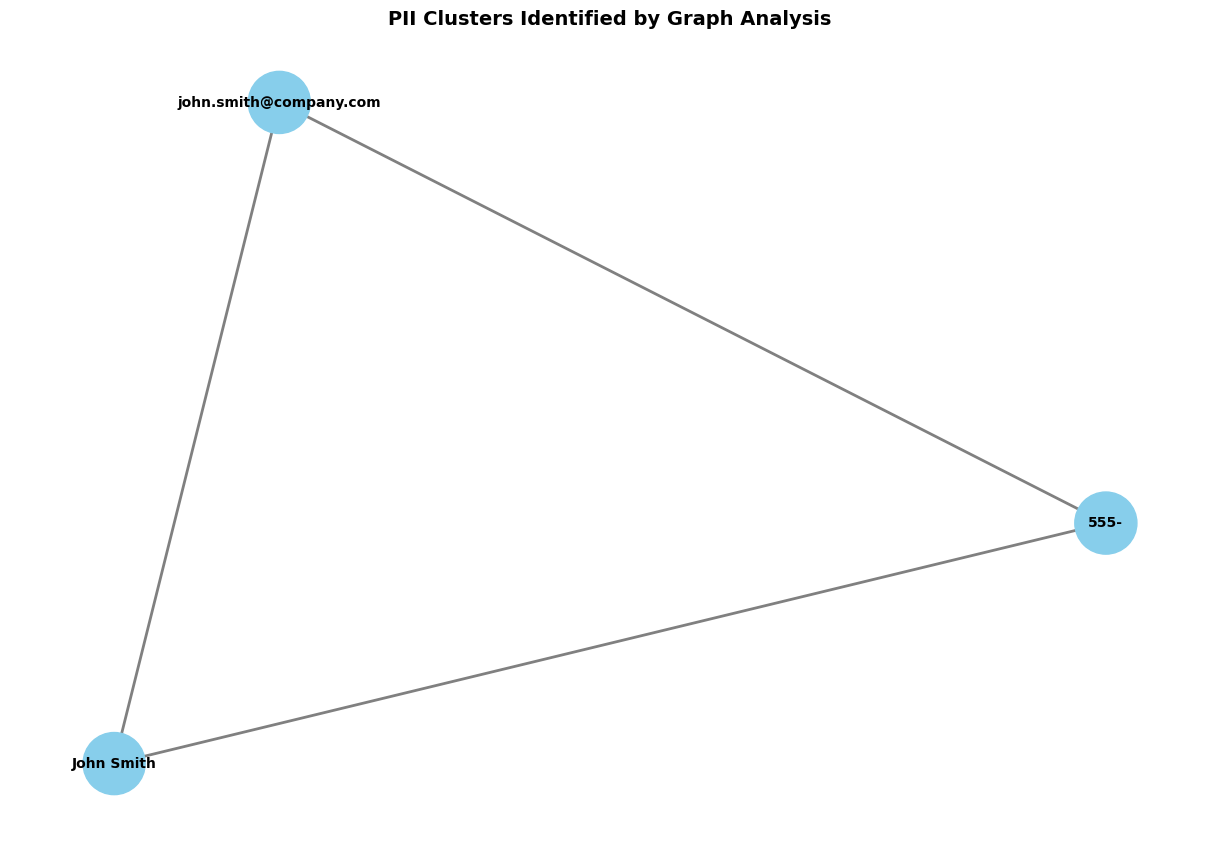



4. DEDUPLICATION DEMONSTRATION
--------------------------------------------------
Text: John Smith (john.smith@email.com) called. John Smith's email is john.smith@email.com. Contact John Smith at john.smith@email.com.
Duplicate PII detected and skipped: john.smith@email.com (Category: EMAIL)
Duplicate PII detected and skipped: john.smith@email.com (Category: EMAIL)
Duplicate PII detected and skipped: john.smith@email.com (Category: EMAIL)
Duplicate PII detected and skipped: john.smith@email.com (Category: EMAIL)
Duplicate PII detected and skipped: john.smith@email.com (Category: EMAIL)
Duplicate PII detected and skipped: john.smith@email.com (Category: Sensitive_Words)
Duplicate PII detected and skipped: john.smith@email.com (Category: Sensitive_Words)
Duplicate PII detected and skipped: John Smith (Category: Names)
Duplicate PII detected and skipped: john.smith@email.com (Category: Addresses)
Graph analysis found 1 PII clusters
  Cluster 1: ['John Smith', "John Smith's", 'john.smith

In [10]:
# Demonstration of Proximity Analysis and Graph Analysis Features

print("=" * 80)
print("DEMONSTRATION OF ADVANCED PII DETECTION FEATURES")
print("=" * 80)

# Proximity Analysis Demonstration
print("\n1. PROXIMITY ANALYSIS DEMONSTRATION")
print("-" * 50)

# True positive case - SSN with context keywords
true_positive = (
    "The employee's SSN is 123-45-6789 and must be kept confidential."
)
print(f"Text: {true_positive}")

detector_tp = Enhanced_PII_Logging(
    true_positive, debug=True, enable_proximity=True, enable_graph=False
)

# False positive case - SSN pattern without context
false_positive = (
    "The model number for the new part is 987-65-4321, which is now in stock."
)
print(f"\nText: {false_positive}")

detector_fp = Enhanced_PII_Logging(
    false_positive, debug=True, enable_proximity=True, enable_graph=False
)

# Graph Analysis Demonstration
print("\n\n2. GRAPH-BASED ANALYSIS DEMONSTRATION")
print("-" * 50)

# Complex text with multiple related PII items
complex_text = """
Customer John Smith (john.smith@company.com, phone: 555-123-4567) 
called about his account. His SSN is 123-45-6789 for verification. 
He lives at 123 Main Street, New York, NY 10001. 
His credit card ending in 1111-2222-3333-4444 was used for the transaction.
"""

print(f"Text: {complex_text.strip()}")

detector_graph = Enhanced_PII_Logging(
    complex_text, debug=True, enable_proximity=True, enable_graph=True
)

# Show the graph visualization
print("\n3. GRAPH VISUALIZATION")
print("-" * 50)

try:
    G, clusters, potential_pii = detector_graph.graph_based_analysis(
        complex_text
    )

    if clusters:
        print(f"Found {len(clusters)} PII clusters:")
        for i, cluster in enumerate(clusters):
            print(f"  Cluster {i+1}: {list(cluster)}")

        # Create visualization
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=42)

        # Color map for clusters
        color_map = []
        colors = [
            "skyblue",
            "lightgreen",
            "salmon",
            "gold",
            "violet",
            "orange",
            "lightcoral",
            "lightblue",
        ]
        node_to_cluster = {
            node: i for i, cluster in enumerate(clusters) for node in cluster
        }

        for node in G.nodes():
            cluster_id = node_to_cluster.get(node, -1)
            color_map.append(colors[cluster_id % len(colors)])

        nx.draw(
            G,
            pos,
            with_labels=True,
            node_color=color_map,
            node_size=2000,
            font_size=10,
            font_weight="bold",
            edge_color="gray",
            width=2,
        )

        plt.title(
            "PII Clusters Identified by Graph Analysis",
            fontsize=14,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()
    else:
        print("No PII clusters found in the text.")

except Exception as e:
    print(f"Graph visualization error: {e}")

# Deduplication Demonstration
print("\n\n4. DEDUPLICATION DEMONSTRATION")
print("-" * 50)

duplicate_text = "John Smith (john.smith@email.com) called. John Smith's email is john.smith@email.com. Contact John Smith at john.smith@email.com."

print(f"Text: {duplicate_text}")

detector_dup = Enhanced_PII_Logging(
    duplicate_text, debug=True, enable_proximity=True, enable_graph=True
)

print(f"\nUnique PII count: {len(detector_dup.UNIQUE_PII)}")
print(f"Unique PII values: {list(detector_dup.UNIQUE_PII)}")